In [75]:
import numpy as np 
import math 
import matplotlib.pyplot as plt
from dataclasses import dataclass, field 
from typing import Callable
%matplotlib inline 

In [76]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ %s|d=%.3f|g=%.3f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [77]:
from __future__ import annotations

@dataclass()
class Value:
    data: int
    grad: float = field (default_factory=float, repr=False)
    _backward: Callable = field(default=lambda: None, repr=False)
    _prev: tuple[Value, Value] = field(default_factory=tuple, repr=False)
    _op: str = field(default_factory=str, repr=False)
    _expr: str = field(default_factory=str, repr=False)
    label: str = field(default_factory=str, repr=False)
    
    def __post_init__(self):
        if not self._expr:
            self._expr = self.label

    def __hash__(self) -> int:
        return id(self)
    
    def __add__(self, other: Value):
        if isinstance(other, (int, float)):
            other = Value(other)
        out = Value(self.data + other.data, _prev=(self, other), _op="+", _expr=f"( {self._expr} + {other._expr} )")
        def backward(): 
            self.grad += out.grad
            other.grad += out.grad  
        out._backward = backward 
        return out 
    
    def __mul__(self, other: Value):
        if isinstance(other, (int, float)):
            other = Value(other)        
        out = Value(self.data * other.data, _prev=(self, other), _op="*",  _expr=f"( {self._expr} * {other._expr} )")
        def backward(): 
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad   
        out._backward = backward 
        return out 
    
    def tanh(self):
        x = self.data 
        out = Value((math.e**(2*x) - 1) / (math.e**(2*x) + 1), _op="tanh", label="tanh", _prev=(self, ))
        def backward(): 
            self.grad += (1 - out.data**2) * out.grad 
        out._backward = backward 
        return out
    
    def __rmul__(self, other):
        return self * Value(other)
    
    def __radd__(self, other):
        return self + Value(other)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, n):
        if not isinstance(n, (int, float)): 
            raise ValueError("power arg needs to be int or float")
        x = self.data 
        out = Value(x**n, _op="x^", label="pow", _prev=(self, ))
        def backward(): 
            self.grad += (n*(x**(n-1))) * out.grad 
        out._backward = backward 
        return out 
    
    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            other = Value(other)
        return self * (other**(-1))
        
    def exp(self):
        x = self.data 
        out = Value(math.e**x, _op="e^", label="exp", _prev=(self, ))
        def backward(): 
            self.grad += (math.e**x) * out.grad 
        out._backward = backward 
        return out 
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo = topo[::-1]
        topo[0].grad = 1.0 # This is very important 
        for node in topo:
            node._backward()
        

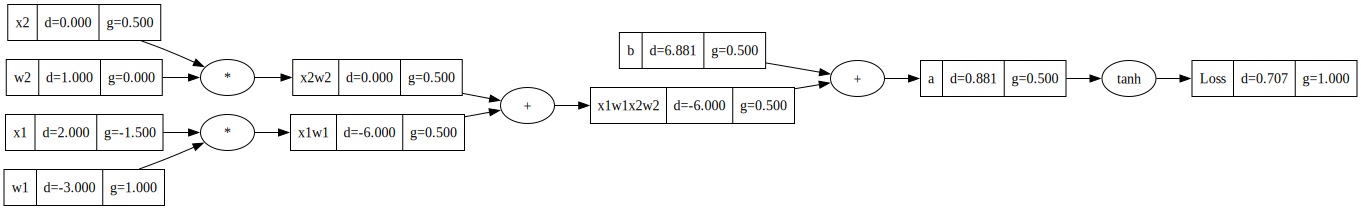

In [78]:
import inspect 

# perceptron 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.881337, label="b")

x1w1 = x1*w1 ; x1w1.label = "x1w1"
x2w2 = x2*w2 ; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b ; n.label = "a"

L = n.tanh() ; L.label = "Loss"

L.backward()
draw_dot(L)


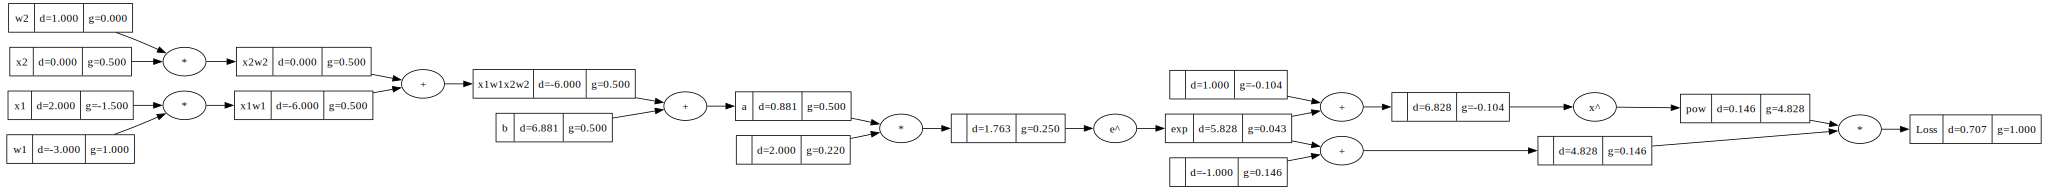

In [79]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.881337, label="b")

x1w1 = x1*w1 ; x1w1.label = "x1w1"
x2w2 = x2*w2 ; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b ; n.label = "a"

e = (2*n).exp()
L = (e - 1) / (e + 1) ; L.label = "Loss"

L.backward()
draw_dot(L)

In [4]:
import torch 

x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad = True
b = torch.tensor([6.881337]).double() ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b 
L = torch.tanh(n)

L.backward()
L.data.item()  

# 
x1.grad.item(), x2.grad.item(), w1.grad.item(), w2.grad.item() 


(-1.5000772619998126, 0.5000257539999375, 1.000051507999875, 0.0)

In [80]:
import random  

class Neuron: 
    def __init__(self, nin):
        self.ws = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, xs):
        act = sum((x*w for x, w in zip(self.ws, xs)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.ws + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, xs):
        outs =[neuron(xs) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs 
    
    def parameters(self):
        return [ 
                param 
                for neuron in self.neurons 
                for param in neuron.parameters()
        ]
    
class MLP:
    def __init__(self, nin, nouts):
        dims = [nin] + nouts
        self.layers = [ Layer(dims[i], dims[i+1]) for i in range(len(dims)-1) ]
    
    def __call__(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs
    
    def parameters(self):
        return [ 
                param 
                for layer in self.layers
                for param in layer.parameters()
        ]

xs = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])

mlp(xs)
    

Value(data=-0.9601380755153589)

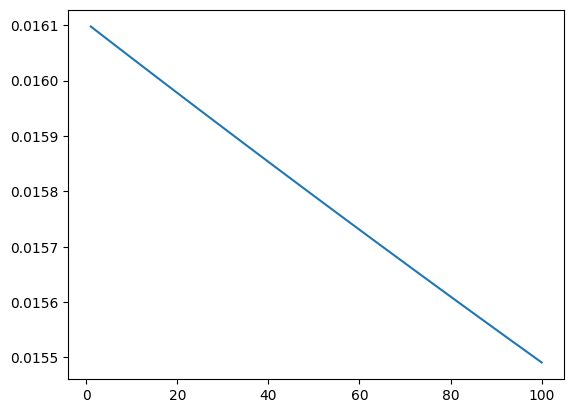

In [95]:
def train(inputs, outputs, learningRate=0.001, iters = 1000, plot = False):
    
    mlp = MLP(len(inputs[0]), [4, 4, 1])
    xss = inputs
    ys = outputs 
    
    lossArr = []
    params = mlp.parameters()

    for i, j in enumerate(range(iters)):
        
        # forward propagate     
        ypreds = [mlp(xs) for xs in xss]
        loss = sum( (y_-y)**2 for y_, y in zip(ypreds, ys))
        
        # backpropagate 
        for param in params:
            param.grad = 0.0
        loss.backward()
        for param in params:
            param.data += (-learningRate * param.grad)
        
        lossArr.append(loss)

    if plot:
        plt.plot(range(1, iters+1), [ v.data for v in lossArr ])
    
